In [15]:
# setups
# One-time install in a notebook cell (comment out after first run)
# !pip install pandas numpy scikit-learn xgboost shap seaborn matplotlib

In [16]:
# required imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [17]:
# Load & peek at the data
# What to look for: do all the columns you expect show up? Are timestamps parsed correctly?
df = pd.read_csv("sample_operational_metrics.csv", parse_dates=["timestamp_utc"])
df.head()

/var/folders/d9/n3r0_rqx0cq6fgkzp8xmfp0r0000gn/T/ipykernel_1668/2698139720.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sample_operational_metrics.csv", parse_dates=["timestamp_utc"])


,timestamp_utc,host_id,service,cpu_pct,mem_pct,disk_used_pct,error_rate,is_holiday,change_deployed_prev_1h,incident_open_in_next_2h,p1_or_p2_next_incident
0,2025-05-14 00:00:00,app-01,payments-api,52.967142,62.317104,69.665187,0.049,0,0,0,NaN
1,2025-05-14 00:05:00,app-01,payments-api,46.617357,50.005628,70.025097,0.002,0,0,0,NaN
2,2025-05-14 00:10:00,app-01,payments-api,54.476885,46.711582,69.501059,0.023,0,0,0,NaN
3,2025-05-14 00:15:00,app-01,payments-api,63.230299,54.159466,71.238636,0.001,0,0,0,NaN
4,2025-05-14 00:20:00,app-01,payments-api,45.658466,57.902765,69.937843,0.003,0,0,0,NaN


In [18]:
# --- Basic preprocessing ---
# 
# 1. Sort by time (safety first)
df = df.sort_values("timestamp_utc")

# 2. Handle obvious outliers or impossible negatives
metric_cols = ["cpu_pct", "mem_pct", "disk_used_pct", "error_rate"]
df[metric_cols] = df[metric_cols].clip(lower=0, upper=100)

# 3. Fill tiny gaps (if any) using forward-fill
df[metric_cols] = df[metric_cols].ffill()

In [19]:
# Feature engineering (rolling windows & lags)
# We’ll create simple rolling-mean features for CPU & memory and a “minutes since last deployment” feature.
# Start small; you can add fancier ones later.

# Rolling Window (a moving average)
# It’s like looking at a sliding window of recent history for a metric (e.g. CPU %).
# Imagine a 30-minute moving average of CPU usage:
# If current CPU is 80%, but it’s been slowly rising from 50% over the last 30 minutes… that’s a risk signal.
# What am I doing here -> df["cpu_mean_30m"] = df["cpu_pct"].rolling(6).mean()
# I am taking the last 6 rows (each = 5 min), average them, and store it.
# Same for 2 hours (24 rows at 5-minute intervals): df["cpu_mean_2h"] = df["cpu_pct"].rolling(24).mean()

# Lag-like Feature: Time since last deployment
# When something breaks, it often happens right after a code change (deployment).
# We want the model to know how long it’s been since the last change.
# This helps the model learn things like: “If we just deployed something and CPU is rising… a problem might be coming.”

# Why we need them ?????
# Without history, the model only sees what’s happening right now.
# With rolling windows and lags, it sees what has been building up over time.
# Just like weather forecasts look at past temperatures and pressure over the last few hours, 
# incident prediction needs trends — not just snapshots.

df["cpu_mean_30m"] = df["cpu_pct"].rolling(6, min_periods=1).mean()
df["cpu_mean_2h"]  = df["cpu_pct"].rolling(24, min_periods=1).mean()
df["mem_mean_30m"] = df["mem_pct"].rolling(6, min_periods=1).mean()
df["mem_mean_2h"]  = df["mem_pct"].rolling(24, min_periods=1).mean()
df["minutes_since_deploy"] = (
    df.groupby("host_id")["change_deployed_prev_1h"]
      .transform(lambda s: (~s.astype(bool)).cumsum())
)

In [20]:
# --- Label Engineering ---
df["incident_open_in_next_24h"] = 0
df["incident_open_in_next_7d"] = 0
incident_indices = df.index[df["incident_open_in_next_2h"] == 1]
for idx in incident_indices:
    df.loc[max(0, idx - 288):idx, "incident_open_in_next_24h"] = 1
    df.loc[max(0, idx - 2016):idx, "incident_open_in_next_7d"] = 1

In [21]:
# --- Additional Labels ---
# CPU Spike for 2h (rolling avg ≥ 90%)
df["cpu_spike_2h"] = (df["cpu_pct"].rolling(24, min_periods=24).mean() >= 90).astype(int)

# Storage usage breach
df["storage_breach"] = (df["disk_used_pct"] >= 90).astype(int)

# P1/P2 severity label
# 0 = None, 1 = P2, 2 = P1
df["incident_severity"] = 0
df.loc[df["p1_or_p2_next_incident"] == "P2", "incident_severity"] = 1
df.loc[df["p1_or_p2_next_incident"] == "P1", "incident_severity"] = 2

In [22]:
# --- Common Features ---
feature_cols = [
    "cpu_pct", "mem_pct", "disk_used_pct", "error_rate",
    "cpu_mean_30m", "cpu_mean_2h",
    "mem_mean_30m", "mem_mean_2h",
    "minutes_since_deploy", "is_holiday"
]

In [23]:
# --- Training & Prediction ---
def train_and_predict(df, label):
    X = df[feature_cols]
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        eval_metric="logloss",
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
    model.fit(X_train, y_train)
    prob = model.predict_proba(df[feature_cols].iloc[-1:])[:, 1][0]
    explainer = shap.Explainer(model)
    shap_values = explainer(df[feature_cols].iloc[-1:])
    return model, prob, shap_values

In [24]:
# --- Dashboard Table ---
labels = ["incident_open_in_next_2h", "incident_open_in_next_24h", "incident_open_in_next_7d", "cpu_spike_2h", "storage_breach"]
summary = []
models = {}
shap_explanations = {}

for label in labels:
    model, prob, shap_values = train_and_predict(df.copy(), label)
    models[label] = model
    shap_explanations[label] = shap_values
    top_index = shap_values.values[0].argmax()
    top_feature_name = df[feature_cols].columns[top_index]
    summary.append({
        "Time Window": label.replace("incident_open_in_next_", "") + " ahead",
        "Risk Score": round(prob, 3),
        "Risk Level": "⚠️ High" if prob >= 0.5 else "✅ Low",
        "Top Feature": top_feature_name
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

,Time Window,Risk Score,Risk Level,Top Feature
0,2h ahead,0.0,✅ Low,mem_mean_30m
1,24h ahead,0.0,✅ Low,mem_mean_30m
2,7d ahead,0.0,✅ Low,mem_mean_30m
3,cpu_spike_2h ahead,0.0,✅ Low,cpu_pct
4,storage_breach ahead,1.0,⚠️ High,disk_used_pct



Top Feature Explanations

Explanation for incident_open_in_next_2h


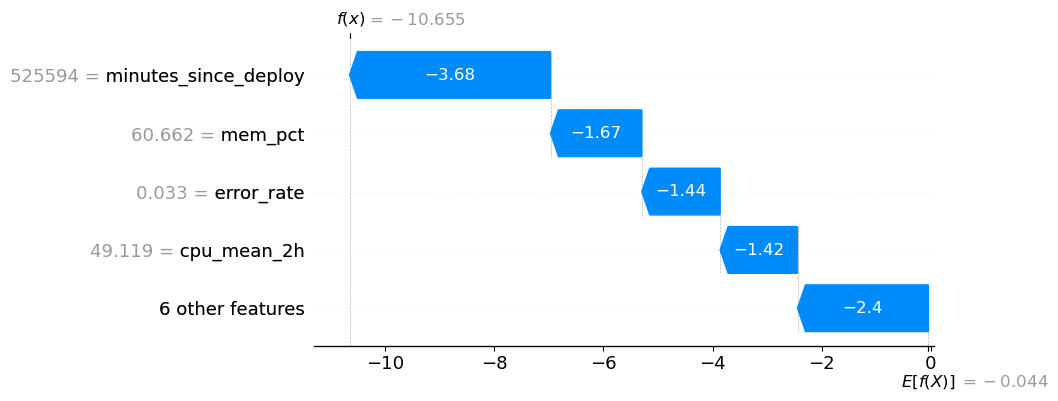


Explanation for incident_open_in_next_24h


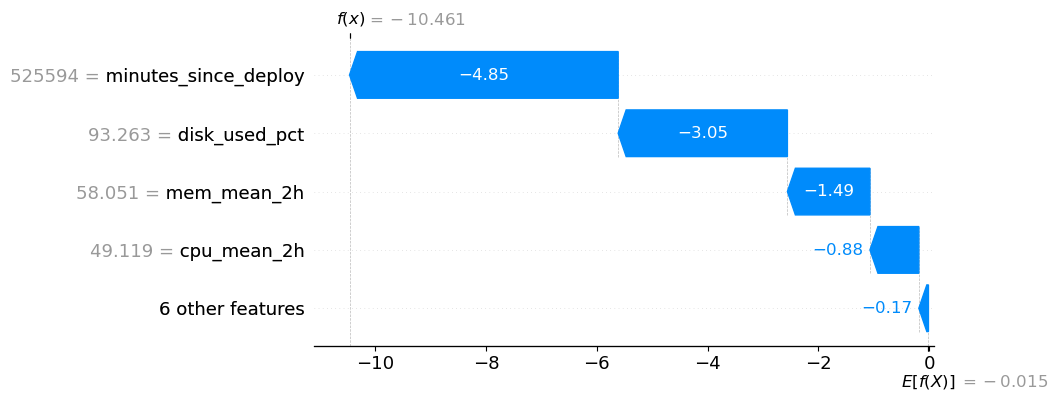


Explanation for incident_open_in_next_7d


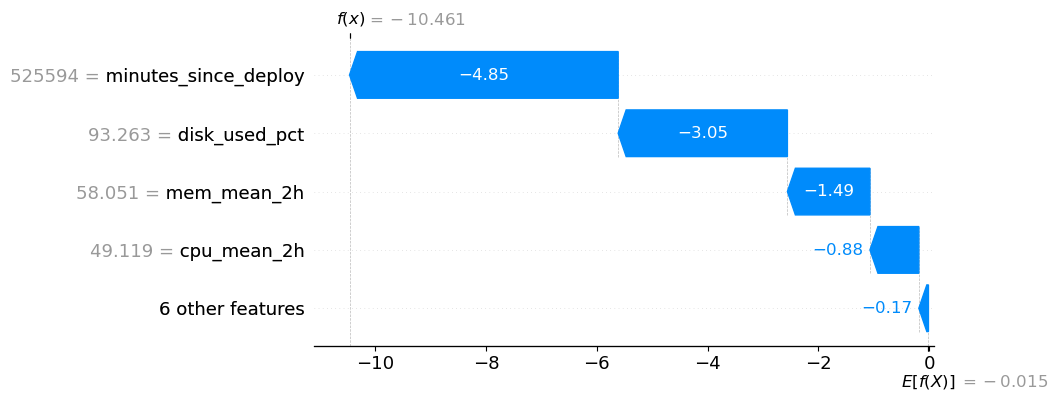


Explanation for cpu_spike_2h


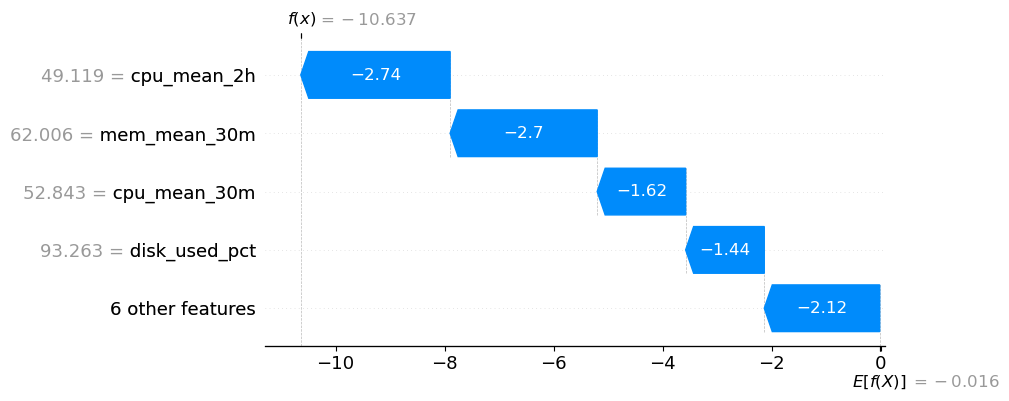


Explanation for storage_breach


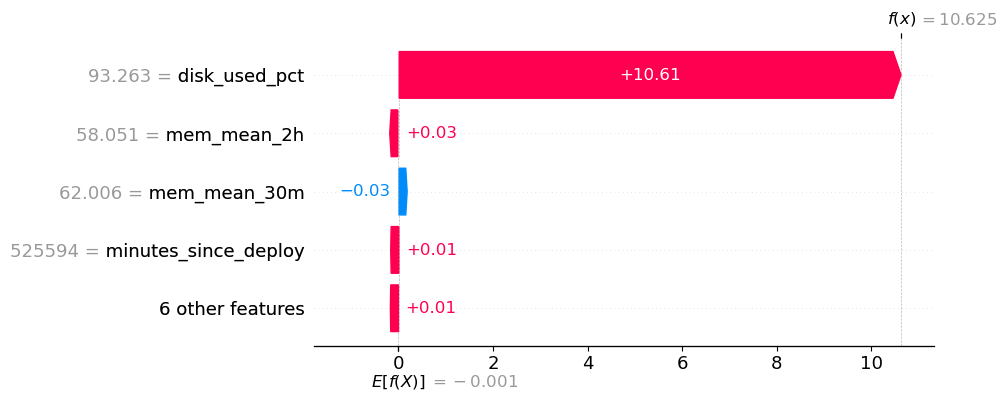

In [25]:
# --- SHAP Plots ---
print("\nTop Feature Explanations")
for label in labels:
    print(f"\nExplanation for {label}")
    shap.plots.waterfall(shap_explanations[label][0], max_display=5)

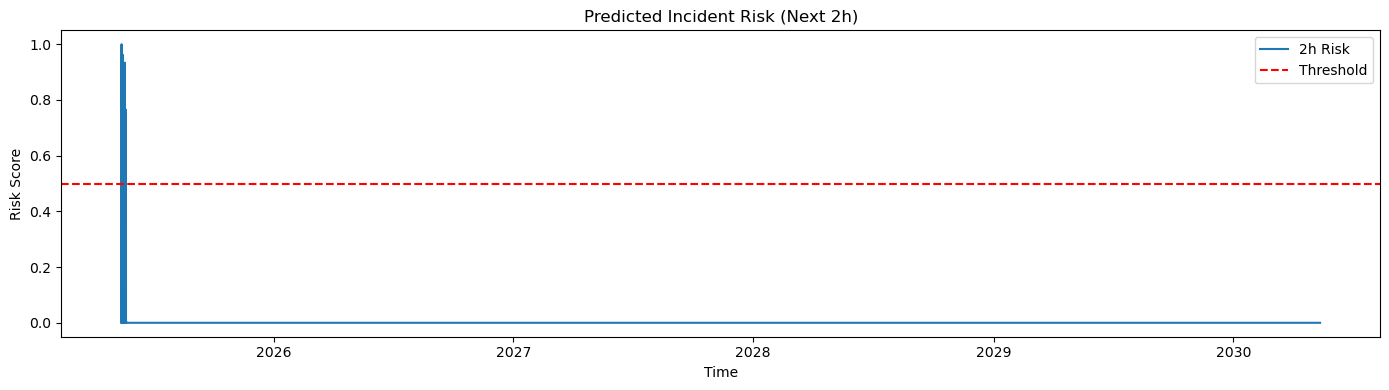

In [26]:
# --- Visualize risk over time (2h example) ---
df["predicted_risk_2h"] = models["incident_open_in_next_2h"].predict_proba(df[feature_cols])[:, 1]
plt.figure(figsize=(14, 4))
plt.plot(df["timestamp_utc"], df["predicted_risk_2h"], label="2h Risk")
plt.axhline(0.5, color='red', linestyle='--', label="Threshold")
plt.title("Predicted Incident Risk (Next 2h)")
plt.ylabel("Risk Score")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# --- Weekly retraining job stub ---
def retrain_weekly(df, label):
    print(f"[Weekly Job] Retraining model for {label}...")
    model, _, _ = train_and_predict(df.copy(), label)
    return model

# Example call:
# weekly_model_2h = retrain_weekly(df, "incident_open_in_next_2h")